In [ ]:
import os
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [ ]:
def calculate_saliency(weight_i, bias_i, weight_j, bias_j, coef_j):
    epsilon = weight_i - weight_j + bias_i - bias_j
    saliency = (coef_j ** 2) * torch.norm(epsilon, 2) ** 2
    return saliency


def get_matrix_saliency(weights, bias, coefs):
    # Calculate the saliency matrix for the given layer
    saliency_matrix = torch.empty((weights.shape[0], weights.shape[0]))
    for i in range(weights.shape[0]):
        for j in range(weights.shape[0]):
            saliency_matrix[i][j] = calculate_saliency(weights[i], bias[i], weights[j], bias[j], coefs[j])
            # calculate_saliency(weights[i], bias[i], weights[j], bias[j], coefs[j])
    return saliency_matrix


def get_smallest_saliency_id(saliency_matrix):
    lowest_saliency = float("inf")
    lowest_saliency_indices = (0, 0)

    for i in range(saliency_matrix.shape[0]):
        for j in range(saliency_matrix.shape[0]):
            # On ne veut pas la diagonale
            if j != i:
                # Calculate the saliency for the current pair of weight sets
                current_saliency = saliency_matrix[i][j]
                # Update the lowest saliency and the corresponding indices if necessary
                if current_saliency < lowest_saliency:
                    lowest_saliency = current_saliency
                    lowest_saliency_indices = (i, j)
    return lowest_saliency_indices


def update_model_and_saliency_matrix(model, saliency_matrix, nbr):
    id = get_smallest_saliency_id(saliency_matrix)
    i, j = id[0], id[1]

    weights = model.fc1.weight
    bias = model.fc1.bias
    coefs = torch.mean(model.fc2.weight.data, dim=0)

    model.fc1.weight.data = torch.cat((weights[:j], weights[j + 1:]))
    model.fc1.bias.data = torch.cat((bias[:j], bias[j + 1:]))

    for nb in range(model.fc2.weight.shape[0]):
        if nb == 0:
            model.fc2.weight.data[nb][i] += model.fc2.weight.data[nb][j]
            new_fc2 = torch.cat((model.fc2.weight.data[nb][:j], model.fc2.weight.data[nb][j + 1:]))
        else:
            model.fc2.weight.data[nb][i] += model.fc2.weight.data[nb][j]
            new_fc2 = torch.cat(
                (new_fc2, torch.cat((model.fc2.weight.data[nb][:j], model.fc2.weight.data[nb][j + 1:]))))

    model.fc2.weight.data = torch.reshape(new_fc2, [nbr, int(int(len(new_fc2)) / nbr)])

    # Update the saliency matrix by removing the j-th column and row
    saliency_matrix = torch.cat((saliency_matrix[:i], saliency_matrix[i + 1:]))
    saliency_matrix = torch.cat((saliency_matrix[:, :j], saliency_matrix[:, j + 1:]), dim=1)

    weights = model.fc1.weight
    bias = model.fc1.bias
    coefs = torch.mean(model.fc2.weight.data, dim=0)

    # Update the saliency values for the remaining weight pairs
    for k in range(saliency_matrix.shape[0]):
        saliency_matrix[k][j] = calculate_saliency(weights[k], bias[k], weights[i], bias[i], coefs[i])

    return saliency_matrix


def update_model_and_saliency_matrix_with_param(model, saliency_matrix, name1, name2, nbr):
    id = get_smallest_saliency_id(saliency_matrix)
    i, j = id[0], id[1]

    layer_obj_1 = getattr(model, name1)
    layer_obj_2 = getattr(model, name2)
    degub = False
    if degub:
        print(f"Type: {layer_obj_1}")
        print(f"Type: {type(layer_obj_1)}")

        print(f"Type: {layer_obj_2}")
        print(f"Type: {type(layer_obj_2)}")

    weights = layer_obj_1.weight
    bias = layer_obj_1.bias
    coefs = torch.mean(layer_obj_2.weight.data, dim=0)

    layer_obj_1.weight.data = torch.cat((weights[:j], weights[j + 1:]))
    layer_obj_1.bias.data = torch.cat((bias[:j], bias[j + 1:]))

    for nb in range(layer_obj_2.weight.shape[0]):
        if nb == 0:
            layer_obj_2.weight.data[nb][i] += layer_obj_2.weight.data[nb][j]
            new_fc2 = torch.cat((layer_obj_2.weight.data[nb][:j], layer_obj_2.weight.data[nb][j + 1:]))
        else:
            layer_obj_2.weight.data[nb][i] += layer_obj_2.weight.data[nb][j]
            new_fc2 = torch.cat(
                (new_fc2, torch.cat((layer_obj_2.weight.data[nb][:j], layer_obj_2.weight.data[nb][j + 1:]))))

    layer_obj_2.weight.data = torch.reshape(new_fc2, [nbr, int(int(len(new_fc2)) / nbr)])

    # Update the saliency matrix by removing the j-th column and row
    saliency_matrix = torch.cat((saliency_matrix[:i], saliency_matrix[i + 1:]))
    saliency_matrix = torch.cat((saliency_matrix[:, :j], saliency_matrix[:, j + 1:]), dim=1)

    weights = layer_obj_1.weight
    bias = layer_obj_1.bias
    coefs = torch.mean(layer_obj_2.weight.data, dim=0)

    # Update the saliency values for the remaining weight pairs
    for k in range(saliency_matrix.shape[0]):
        saliency_matrix[k][j] = calculate_saliency(weights[k], bias[k], weights[i], bias[i], coefs[i])

    return saliency_matrix


def get_saliency_smallest_id(weights, bias, coefs):
    # Initialize the lowest saliency and the corresponding indices
    lowest_saliency = float("inf")
    lowest_saliency_indices = (0, 0)

    for i in range(weights.shape[0]):
        for j in range(weights.shape[0]):
            # On ne veut pas la diagonale
            if j != i:
                # Calculate the saliency for the current pair of weight sets
                current_saliency = calculate_saliency(weights[i], bias[i], weights[j], bias[j], coefs[j])
                # Update the lowest saliency and the corresponding indices if necessary
                if current_saliency < lowest_saliency:
                    lowest_saliency = current_saliency
                    lowest_saliency_indices = (i, j)
    return lowest_saliency_indices


def plot_accuracy_vs_neurons_pruned(accuracy, neurons_pruned):
    plt.plot(neurons_pruned, accuracy)
    plt.xlabel('Number of Neurons Pruned')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Number of Neurons Pruned')
    plt.show()


def pruning(model, nb, name1, name2, device, optimizer, test_loader, nbr, plot=False):
    time0 = time.time()
    neurones_pruned = [i for i in range(0,nb+1, 2)]
    accuracy = []
    pruning_durations = []
    compressions = []
    layer_obj_1 = getattr(model, name1)
    layer_obj_2 = getattr(model, name2)

    weights = layer_obj_1.weight
    bias = layer_obj_1.bias
    coefs = torch.mean(layer_obj_2.weight.data, dim=0)

    # Premier calcul de la matrice de saliency
    matrix_saliency = get_matrix_saliency(weights, bias, coefs)

    # Le pruning commence. Il suffit d'appeler autant de fois cette fonction que l'on veut :)
    for i in range(nb + 1):
        matrix_saliency = update_model_and_saliency_matrix_with_param(model, matrix_saliency, name1, name2, nbr)
        if i in neurones_pruned and plot:
            time1 = time.time()
            model.to(device)
            acc, loss = test(model, device, test_loader)
            accuracy.append(acc)
            pruning_durations.append(time1 - time0)

            # Save model after pruning
            torch.save(model.state_dict(), 'model_after_pruning.pth')
            torch.save(optimizer.state_dict(), 'optimizer_after_pruning.pth')
            size_before_pruning = os.path.getsize("model_before_pruning.pth")
            size_after_pruning = os.path.getsize("model_after_pruning.pth")
            compression = size_before_pruning / size_after_pruning
            compressions.append(compression)
            print(f"Number of pruned neurons: {i}")
            print(f"Time for the pruning : {round(time1 - time0)} secondes")
            print(f"Accuracy after pruning: {acc} (loss {loss})\n")
            print(f"Compression : {compression}")
            print(f"Size before pruning = {human_bytes(size_before_pruning)}\n"
                  f"Size after pruning = {human_bytes(size_after_pruning)}\n"
                  f"Différence = {human_bytes(size_before_pruning - size_after_pruning)}")

    return accuracy, neurones_pruned, pruning_durations, compressions

In [ ]:
import math as m

MULTIPLES = ["B", "k{}B", "M{}B", "G{}B", "T{}B", "P{}B", "E{}B", "Z{}B", "Y{}B"]


def human_bytes(i, binary=False, precision=2):
    base = 1024 if binary else 1000
    multiple = m.trunc(m.log2(i) / m.log2(base))
    value = i / m.pow(base, multiple)
    suffix = MULTIPLES[multiple].format("i" if binary else "")
    return f"{value:.{precision}f} {suffix}"


In [ ]:
class CaffeNet(nn.Module):
    def __init__(self):
        super(CaffeNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)

        self.relu2 = nn.ReLU()

        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=92, kernel_size=3, stride=1, padding=1)

        self.relu3 = nn.ReLU()

        self.conv4 = nn.Conv2d(in_channels=92, out_channels=92, kernel_size=3, stride=1, padding=1)

        self.relu4 = nn.ReLU()

        self.conv5 = nn.Conv2d(in_channels=92, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu5 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.fc1 = nn.Linear(in_features=256, out_features=128)

        self.relu6 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=128, out_features=128)
        self.relu7 = nn.ReLU()
        self.fc3 = nn.Linear(in_features=128, out_features=10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.relu3(x)

        x = self.conv4(x)
        x = self.relu4(x)

        x = self.conv5(x)
        x = self.relu5(x)
        x = self.pool3(x)

        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu6(x)
        x = self.fc2(x)
        x = self.relu7(x)
        x = self.fc3(x)
        
        output = F.log_softmax(x, dim=1)
        return output


In [ ]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [ ]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accu = 100. * correct / len(test_loader.dataset)

    return accu, test_loss

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.298160
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.305733
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.294021
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.319646
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.291719
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.899945
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.740479
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.683892
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.763824
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.295985
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.903772
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.721425
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.569463
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.052858
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.533664
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.393783
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.611171
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.301760
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.323090
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.463596
Train Epoch: 1 [12800/60000 (

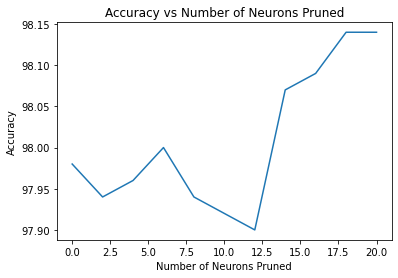

Number of pruned neurons: 0
Time for the pruning : 2 secondes
Accuracy after pruning: 98.14 (loss 0.05983488998413086)

Compression : 1.0335797864254574
Size before pruning = 1.01 MB
Size after pruning = 980.17 kB
Différence = 32.91 kB
Number of pruned neurons: 2
Time for the pruning : 5 secondes
Accuracy after pruning: 98.13 (loss 0.06074033432006836)

Compression : 1.0345254713426333
Size before pruning = 1.01 MB
Size after pruning = 979.28 kB
Différence = 33.81 kB
Number of pruned neurons: 4
Time for the pruning : 7 secondes
Accuracy after pruning: 98.11 (loss 0.060640977096557615)

Compression : 1.0356083753384862
Size before pruning = 1.01 MB
Size after pruning = 978.25 kB
Différence = 34.83 kB
Accuracy: [98.14, 98.13, 98.11]
neurones_pruned: [0, 2, 4]
pruning_durations: [2.3978233337402344, 4.5099403858184814, 6.629476070404053]
compressions: [1.0335797864254574, 1.0345254713426333, 1.0356083753384862]


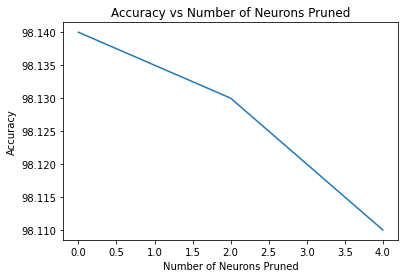

In [ ]:
# Training settings
batch_size = 64
test_batch_size = 1000
epochs = 1
lr = 1.0

# Use GPU
use_cuda = torch.cuda.is_available()
use_mps = torch.backends.mps.is_available()

if use_cuda:
    device = torch.device("cuda")
elif use_mps:
    device = torch.device("mps")
else:
    device = torch.device("cpu")

train_kwargs = {'batch_size': batch_size}
test_kwargs = {'batch_size': test_batch_size}
if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                    'pin_memory': True,
                    'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

# Load MNIST dataset
transform = transforms.Compose([
    #transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_dataset = datasets.MNIST(root='/data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='/data', train=False, download=True, transform=transform)

# Define data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, **train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, **test_kwargs)

# Initialize model, loss and optimizer


model = CaffeNet().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

acc, loss = test(model, device, test_loader)
print(f"\nAccuracy before pruning: {acc} (loss {loss})")

torch.save(model.state_dict(), 'model_before_pruning.pth')
torch.save(optimizer.state_dict(), 'optimizer_before_pruning.pth')

accuracy, neurones_pruned, pruning_durations, compressions = pruning(model, 20, "fc1", "fc2", device, optimizer, test_loader, 128, True)
print(f"Accuracy: {accuracy}")
print(f"neurones_pruned: {neurones_pruned}")
print(f"pruning_durations: {pruning_durations}")
print(f"compressions: {compressions}")
plot_accuracy_vs_neurons_pruned(accuracy, neurones_pruned)


accuracy, neurones_pruned, pruning_durations, compressions = pruning(model, 5, "fc2", "fc3", device, optimizer, test_loader, 10, True)
print(f"Accuracy: {accuracy}")
print(f"neurones_pruned: {neurones_pruned}")
print(f"pruning_durations: {pruning_durations}")
print(f"compressions: {compressions}")
plot_accuracy_vs_neurons_pruned(accuracy, neurones_pruned)